# **Coursera Capstone Project - Optimal Locations for Coffee Shops in Toronto**
*A Python workbook created by Catherine Gao*

In this capstone project, I will leverage the Foursquare location data to solve a real-world business problem.

## **1. Introduction/Business Problem**
In this capstone project, I will identify the optimal locations to open a coffee shop in the city of Toronto, Ontario. Toronto is one of the major cities in Canada. Being one of the country's populous metropolitan areas, Toronto is an international centre for business and finance, and home to numerous tourists from all over the world. 


Opening a coffee shop in this city represents business opportunity but also strong competition at the same time. This project will explore clusters of neighborhoods in Toronto to recommend locations for a good coffee shop business.


The target audience of this project will be those who desire to open a coffee shop in the city of Toronto. Those who are interested in opening a business in Toronto or other metropolitan areas can apply the same analysis to their choice of business.


## **2. Data**

This project will leverage the following two data sets:
1. Toronto Postall Codes Wikipedia Page - I will scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data on postal codes and boroughs in the city of Toronto. 

2. Foursquare location data - an API that provides multi-dimensional data on geolocations, venues, and attributes. This data will help to identify types of business in a specific area and their associated ranks. A link to connect to Foursquare's API platform can be found here: https://developer.foursquare.com/. 

3. Geolocation csv file - a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data. This data will be used to visualize the clusters of neighborhoods on a folium map. 




## **3. Exploratory Data Analysis**

which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

### 3.1 Data Processing

First, scrape data and clean up neighborhood data for Toronto. Put it into an acational pandas dataframe. 

More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma.

Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned. If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [1]:
# import the libraries as instructed

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# for data visualization
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# web scraping
from bs4 import BeautifulSoup

sns.set(rc={'figure.figsize':(15,10)})
sns.set_context("paper")
sns.set_theme(style='ticks')

In [2]:
# get data from wiki page
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')

table = soup.find('table') # the data sits in the first table of the web page

df=[]

for tr in table.findAll('tr'):
  td = tr.findAll('td')
  value = [tr.text for tr in td]
  df.append(value)

In [3]:
# create a dataframe table
df = pd.DataFrame(df, columns = ['PostalCode', 'Borough', 'Neighborhood'])
df['PostalCode'] = df['PostalCode'].str.strip('\n')
df['Borough'] = df['Borough'].str.strip('\n')
df['Neighborhood'] = df['Neighborhood'].str.strip('\n')
df.drop(index=0, inplace=True)

In [4]:
# remove borough with "not assigned" values
df = df[df.Borough != 'Not assigned'].reset_index()
df = df.drop(columns='index', axis=1)

In [5]:
# display dataframe
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


### 3.2 Loading Geolocation Data
Use the Geocoder csv file for the geographical coordinates of each postal code.

In [6]:
geodata = pd.read_csv('/Users/gaogao/Desktop/Geospatial_Coordinates.csv')
geodata.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the two data sets on matching Postal Code.

In [7]:
newdf = df.merge(geodata, how='left', left_on='PostalCode', right_on='Postal Code')
newdf.drop(columns='Postal Code', axis=1, inplace=True)
newdf.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


### 3.3 Display Boroughs in Toronto on a Map

First, I will use geopy library to get the latitude and longitude values of Toronto, Ontario. Then I will add markers on the map to represent the locations of boroughs.

In [8]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [9]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers for boroughs
for lat, lng, borough, neighborhood in zip(newdf['Latitude'], newdf['Longitude'], newdf['Borough'], newdf['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### 3.4 Use Foursquare Data to Understand the Businesses in the Neighborhoods

Let's get the top 100 venues that are in these neighborhoods within a radius of 500 meters.

In [10]:
# removed credential for privacy
print('Your credentails:')
print('CLIENT_ID: Removed for privacy.' )
print('CLIENT_SECRET: Removed for privacy.')

Your credentails:
CLIENT_ID: Removed for privacy.
CLIENT_SECRET: Removed for privacy.


In [14]:
#@title
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
toronto_venues = getNearbyVenues(names=newdf['Neighborhood'],
                                   latitudes=newdf['Latitude'],
                                   longitudes=newdf['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [16]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 273 uniques categories.


By display the top 10 venue categories in Toronto, we notice there are many coffee shops and cafes in the area. This represents substantial competition to any new coffee shop businesses.

In [17]:
df_plot = toronto_venues.groupby('Venue Category').size().sort_values(ascending=False).to_frame(name='count').reset_index().head(10)

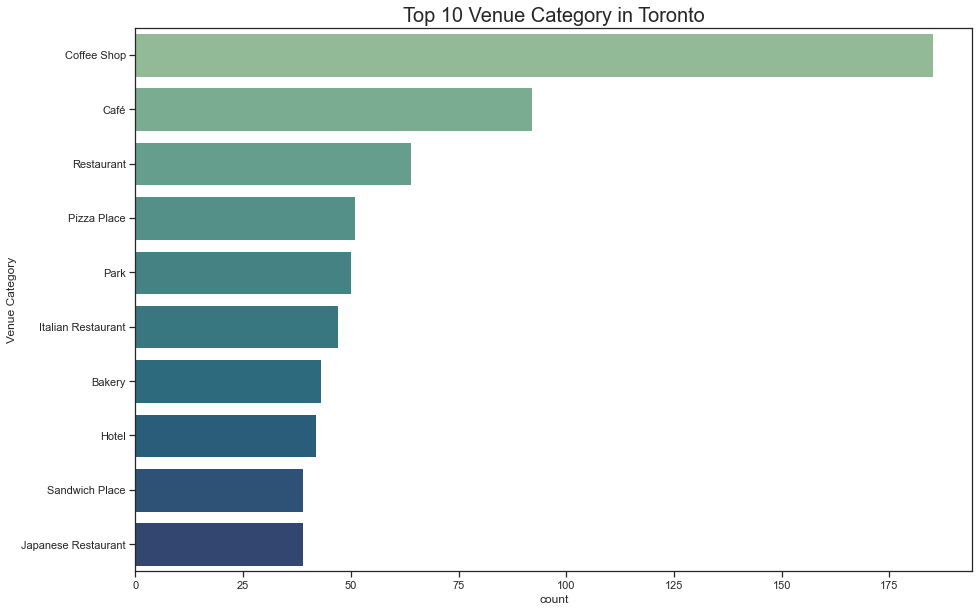

In [18]:
# display top 10 venue categories in Toronto

sns.barplot(data=df_plot, x='count', y='Venue Category', palette='crest')
plt.title('Top 10 Venue Category in Toronto', size=20)
plt.show()

In [19]:
df_plot = toronto_venues.groupby('Neighborhood')['Venue Category'].size().sort_values(ascending=False).to_frame().reset_index().head(20)

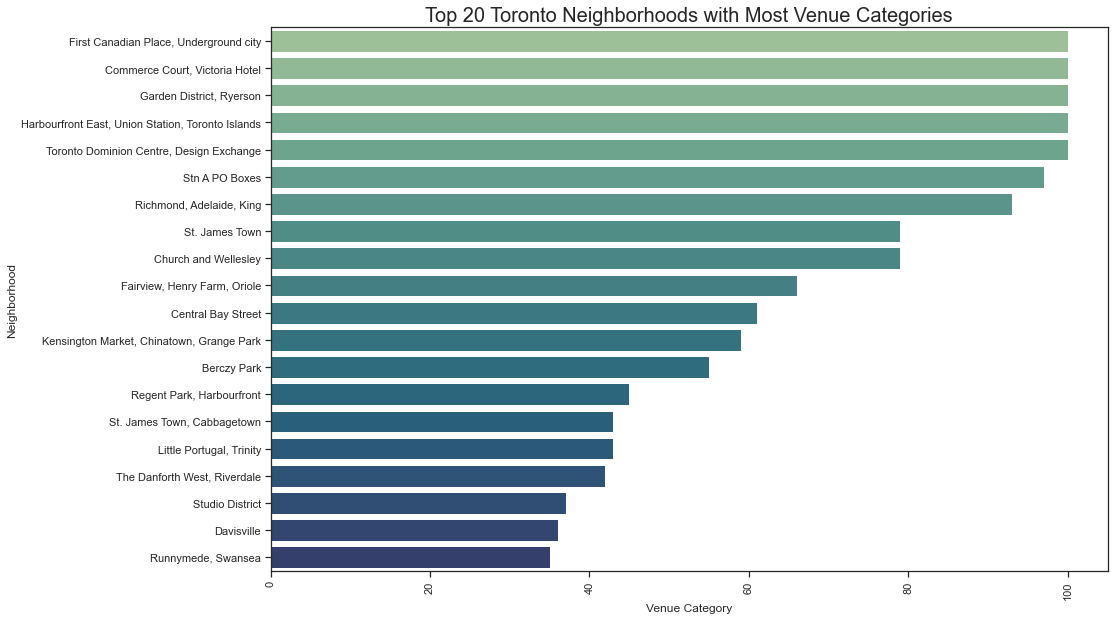

In [20]:
# display top 20 neighborhoods with most venue categories
sns.barplot(data=df_plot, x='Venue Category', y='Neighborhood', palette='crest')
plt.title('Top 20 Toronto Neighborhoods with Most Venue Categories', size=20)
plt.xticks(rotation=90)

plt.show()

Identify the top 10 venue categories for each neighborhood. 

In [21]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [22]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [23]:
#@title
# display the top 10 venues for each neighborhood
# write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# create a function to return top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Lounge,Latin American Restaurant,Breakfast Spot,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Skating Rink,Pub,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Fried Chicken Joint,Shopping Mall,Bridal Shop,Diner,Sandwich Place,Deli / Bodega,Middle Eastern Restaurant
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Women's Store,Butcher,Restaurant,Café,Pub,Pizza Place,Comfort Food Restaurant


Now let's compile a list of neighborhoods that have "Coffee Shop" or "Cafe" as the 1st most common venue.

In [24]:
neighborhoods_venues_sorted[(neighborhoods_venues_sorted['1st Most Common Venue'] == 'Coffee Shop') | (neighborhoods_venues_sorted['1st Most Common Venue'] == 'Café')]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Fried Chicken Joint,Shopping Mall,Bridal Shop,Diner,Sandwich Place,Deli / Bodega,Middle Eastern Restaurant
5,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Beer Bar,Farmers Market,Seafood Restaurant,Cheese Shop,Restaurant,Clothing Store,Juice Bar
7,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Bakery,Stadium,Burrito Place,Furniture / Home Store,Restaurant,Climbing Gym,Nightclub
11,Canada Post Gateway Processing Centre,Coffee Shop,Hotel,Mediterranean Restaurant,American Restaurant,Intersection,Food Truck,Sandwich Place,Gas Station,Burrito Place,Middle Eastern Restaurant
13,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Salad Place,Bubble Tea Shop,Burger Joint,Poke Place,Comic Shop,Office
15,Church and Wellesley,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Yoga Studio,Men's Store,Fast Food Restaurant,Café,Mediterranean Restaurant
18,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Café,Hotel,Gym,American Restaurant,Italian Restaurant,Deli / Bodega,Japanese Restaurant,Seafood Restaurant
29,"First Canadian Place, Underground city",Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Salad Place,Seafood Restaurant,Steakhouse,Deli / Bodega
31,"Garden District, Ryerson",Coffee Shop,Clothing Store,Middle Eastern Restaurant,Italian Restaurant,Bubble Tea Shop,Japanese Restaurant,Café,Cosmetics Shop,Hotel,Theater
35,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Aquarium,Café,Hotel,Italian Restaurant,Fried Chicken Joint,Brewery,Restaurant,Scenic Lookout,Bank


### 3.5 Clustering the Neighborhoods

Run k-means to cluster the neighborhood into 6 clusters using the Foursquare venue data.

In [25]:
# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)


In [26]:
# Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

toronto_merged = newdf

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.merge(neighborhoods_venues_sorted, how='left', left_on='Neighborhood', right_on='Neighborhood')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Park,Food & Drink Shop,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Pizza Place,Coffee Shop,Hockey Arena,Portuguese Restaurant,Intersection,Dumpling Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Electronics Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Restaurant,Café,Theater,French Restaurant,Farmers Market
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Women's Store,Sporting Goods Shop,Boutique,Miscellaneous Shop,Furniture / Home Store,Carpet Store,Event Space,Coffee Shop,Accessories Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,College Cafeteria,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,Portuguese Restaurant


In [30]:
# check and display any NA values after merge
toronto_merged[toronto_merged['Cluster Labels'].isna()]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These rows have NA because no venue data was returned for these neighborhood from Foursquare. We will label these as "6" in clusters.

In [34]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].fillna(6)

In [36]:
# convert float to integer
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Park,Food & Drink Shop,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Pizza Place,Coffee Shop,Hockey Arena,Portuguese Restaurant,Intersection,Dumpling Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Electronics Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Restaurant,Café,Theater,French Restaurant,Farmers Market
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Women's Store,Sporting Goods Shop,Boutique,Miscellaneous Shop,Furniture / Home Store,Carpet Store,Event Space,Coffee Shop,Accessories Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,College Cafeteria,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,Portuguese Restaurant


In [40]:
toronto_merged.groupby('Cluster Labels').size().to_frame(name='count').reset_index()

,Cluster Labels,count
0,0,85
1,1,1
2,2,10
3,3,2
4,4,1
5,5,1
6,6,3


Visualize the clusters!

In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3.6 Explore the Clusters
Cluster 1


In [83]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster1.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0,Pizza Place,Coffee Shop,Hockey Arena,Portuguese Restaurant,Intersection,Dumpling Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Electronics Store
2,Downtown Toronto,0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Restaurant,Café,Theater,French Restaurant,Farmers Market
3,North York,0,Clothing Store,Women's Store,Sporting Goods Shop,Boutique,Miscellaneous Shop,Furniture / Home Store,Carpet Store,Event Space,Coffee Shop,Accessories Store
4,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,College Cafeteria,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,Portuguese Restaurant
6,Scarborough,0,Fast Food Restaurant,Print Shop,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Donut Shop


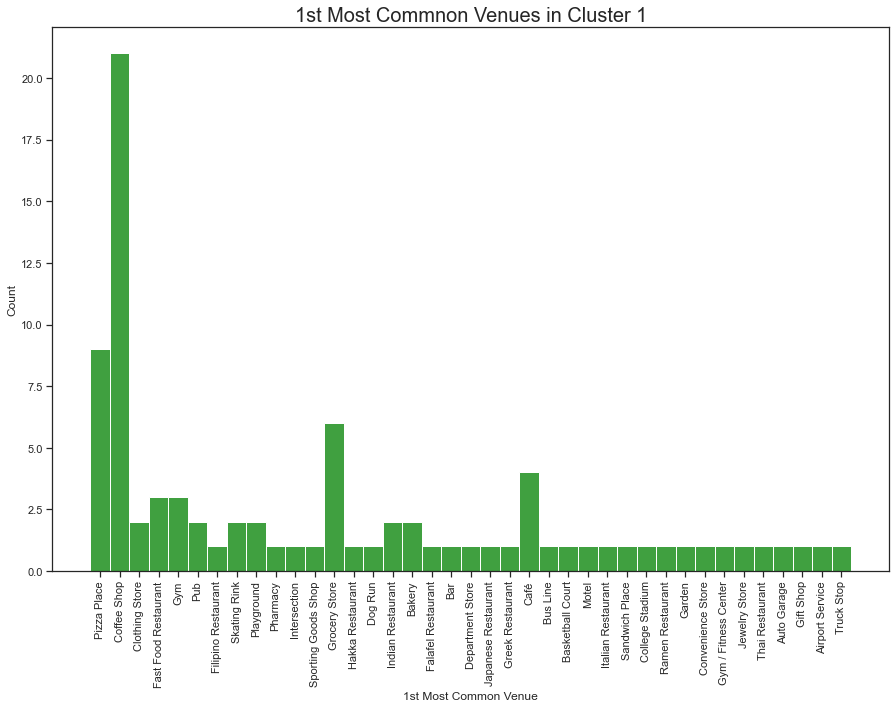

In [67]:
sns.histplot(data=cluster1, x='1st Most Common Venue', color='green')
plt.title('1st Most Commnon Venues in Cluster 1', size=20)
plt.xticks(rotation=90)

plt.show()

Cluster 2

In [84]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster2.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Scarborough,1,Bar,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Farmers Market


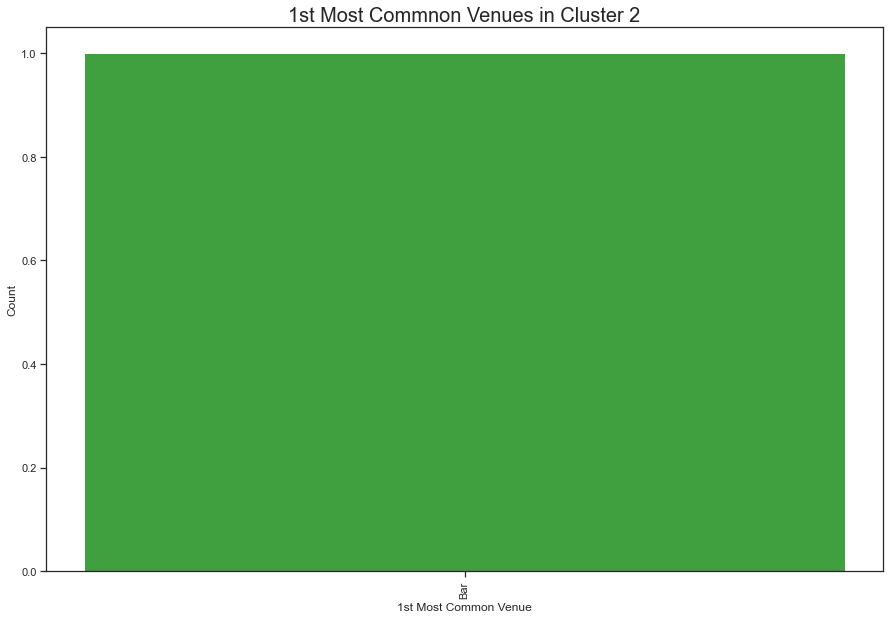

In [69]:
# plot gragh
sns.histplot(data=cluster2, x='1st Most Common Venue', color='green')
plt.title('1st Most Commnon Venues in Cluster 2', size=20)
plt.xticks(rotation=90)

plt.show()

Cluster 3

In [85]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster3.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2,Park,Food & Drink Shop,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
21,York,2,Park,Women's Store,Pool,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
35,East York,2,Park,Convenience Store,Metro Station,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
52,North York,2,Park,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
61,Central Toronto,2,Bus Line,Park,Swim School,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store


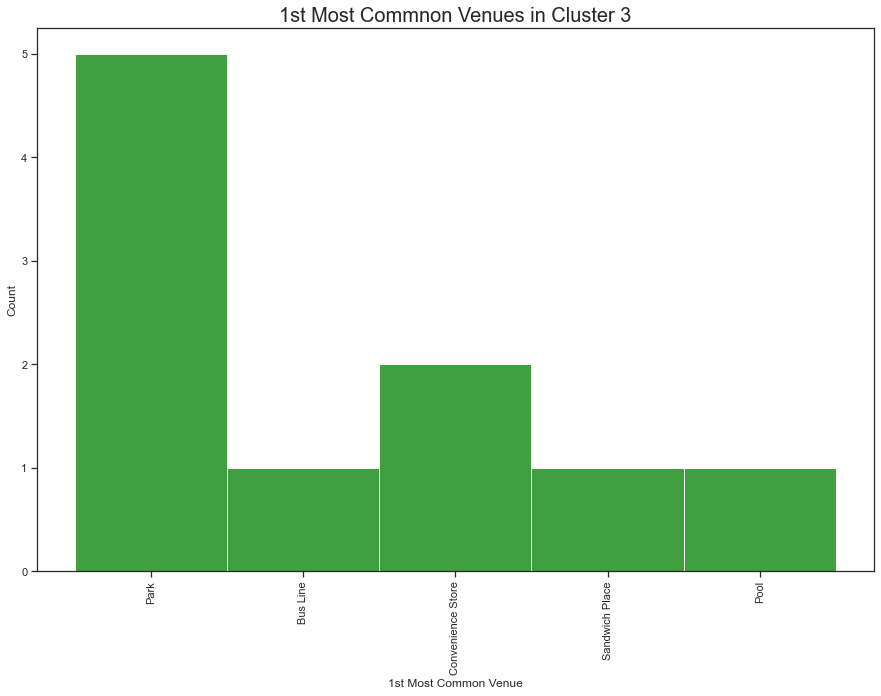

In [70]:
# plot gragh
sns.histplot(data=cluster3, x='1st Most Common Venue', color='green')
plt.title('1st Most Commnon Venues in Cluster 3', size=20)
plt.xticks(rotation=90)

plt.show()

Cluster 4

In [87]:
cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster4.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,North York,3,Baseball Field,Paper / Office Supplies Store,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
101,Etobicoke,3,Baseball Field,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store,Farmers Market


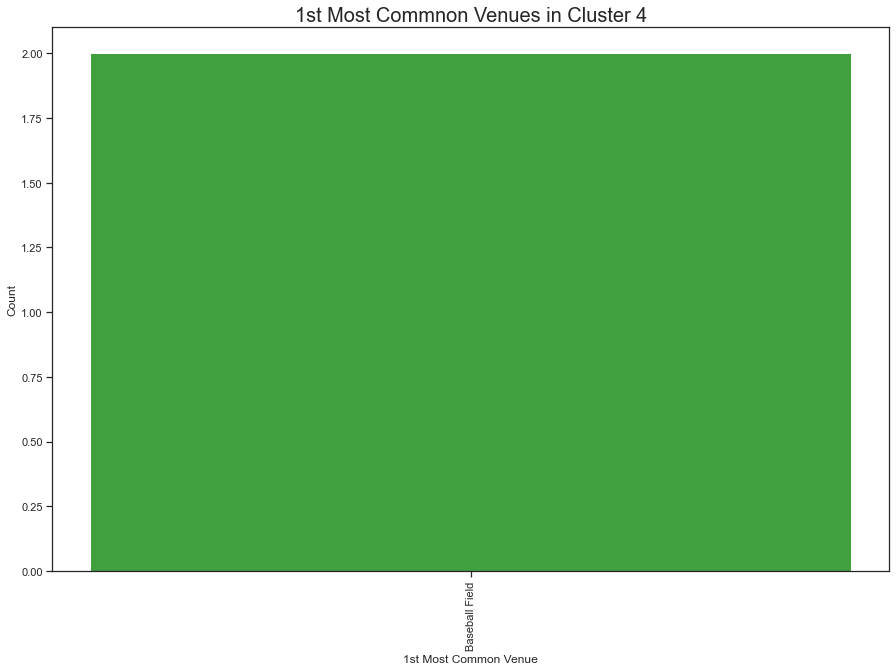

In [71]:
# plot gragh
sns.histplot(data=cluster4, x='1st Most Common Venue', color='green')
plt.title('1st Most Commnon Venues in Cluster 4', size=20)
plt.xticks(rotation=90)

plt.show()

Cluster 5

In [88]:
cluster5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster5.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
83,Central Toronto,4,Restaurant,Summer Camp,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant


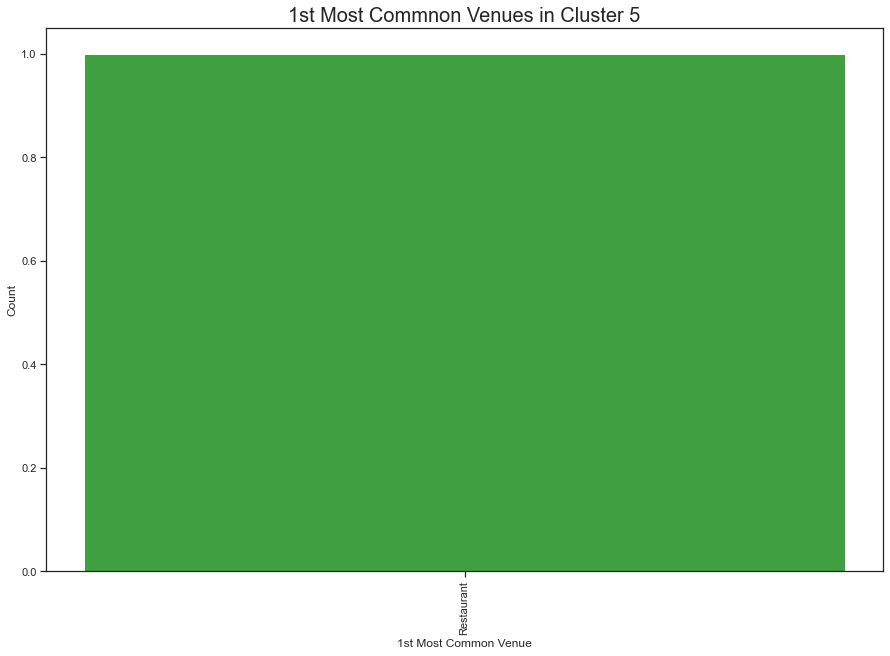

In [72]:
# plot gragh
sns.histplot(data=cluster5, x='1st Most Common Venue', color='green')
plt.title('1st Most Commnon Venues in Cluster 5', size=20)
plt.xticks(rotation=90)

plt.show()

Cluster 6

In [89]:
cluster6 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster6.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Scarborough,5,Playground,Spa,College Gym,College Rec Center,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop


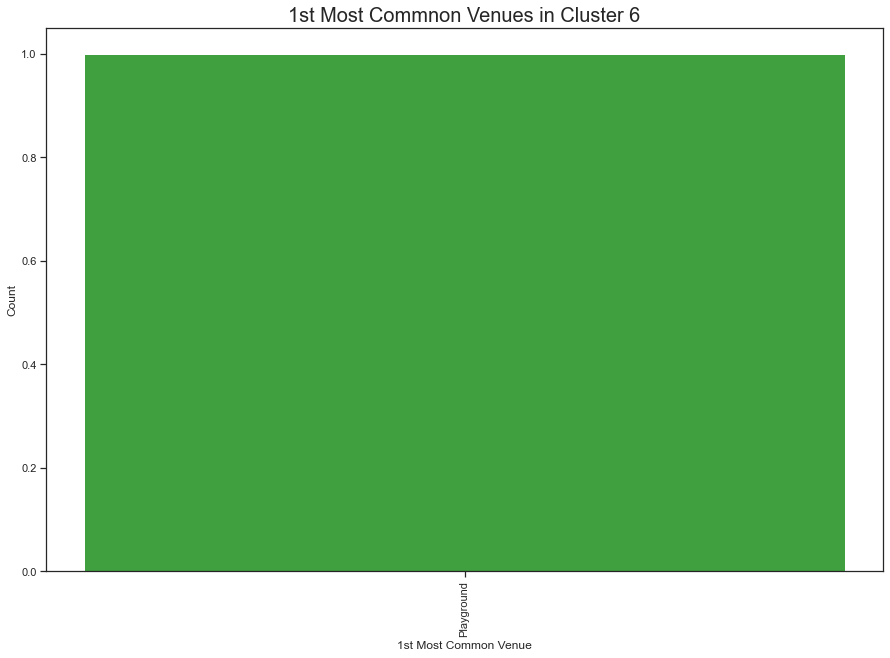

In [73]:
# plot gragh
sns.histplot(data=cluster6, x='1st Most Common Venue', color='green')
plt.title('1st Most Commnon Venues in Cluster 6', size=20)
plt.xticks(rotation=90)

plt.show()

## **4. Results and Discussion**
Cluster 1 contains the most diverse profile of venue categories, and coffee shop is the most common venue category in this cluster. From the sample detail of Cluster 1, these areas are most likely the financial/shopping districts in Toronto with many shops and event spaces. Cluster 3 also has a diverse profile of business types, but the most common venue category is park. The sample data of Cluster 3 shows that the area is mainly consisted of parks, transportaion stations, and distribution centers. Cluster 3 is mostly lcoated in the remote areas of Toronto. The other clusters only have 1 member. 

## **5. Discussion**
This project identifies the optimal location for a new coffee shopp business based on the popular venue category in eacch neighborhood. However, other factors should also be accounted for when making business decisions. For example, the type of neighborhood will create different customer traffic in different times of the day. A commercial neighborhood will have more traffic during the weekdays while a residential neighborhood will likely to havee more traffic on the weekends. The demoograrphics are also important, given people from one culture might prefer drinking coffee than people from other cultures. 

## **6. Conclusion**

Based on the cluster analysis, we can conclude that neighborhoods in cluster 1 will have most customer trafic but also strong business competition. Cluster 3 is represents a good opportunith with less competiton, but might also have slow business growth for a coffee shop business. Other factors such as demographic components and neighborhood type should also be taken into consideration.